# Отток клиентов

Начал наблюдаться уход клиентов из банка. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Необходимо спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. У нас есть исторические данные о поведении клиентов и расторжении договоров с банком. 

Задача - построить модель с предельно большим значением *F1*-меры. Целевое значение метрики - не ниже 0.59.

Также необходимо дополнительно измерять *AUC-ROC* и сравнивать её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

### Подготовим неоходимые для работы библиотеки

In [273]:
import pandas as pd

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler 

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

### Изучим данные внутри датафрейма и сделаем необходимую предобработку

In [274]:
pd.set_option('display.max_columns', None) #будем отображать все столбцы
data = pd.read_csv('/datasets/Churn.csv') #читаем файл в переменную data
display(data.shape); #выведем размер датасета
display(data.head()); #выведем первые 5 строк датасета
display(data.info()); #выведем информацию о типах данных и пропусках в датасете

(10000, 14)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


None

**Признаки:**
- RowNumber — индекс строки в данных
- CustomerId — уникальный идентификатор клиента
- Surname — фамилия
- CreditScore — кредитный рейтинг
- Geography — страна проживания
- Gender — пол
- Age — возраст
- Tenure — сколько лет человек является клиентом банка
- Balance — баланс на счёте
- NumOfProducts — количество продуктов банка, используемых клиентом
- HasCrCard — наличие кредитной карты
- IsActiveMember — активность клиента
- EstimatedSalary — предполагаемая зарплата

**Целевой признак:**
- Exited — факт ухода клиента

In [275]:
data.describe() #выведем информацию о распределении значений в данных датасета

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


**Видим, что значения различных признаков очень сильно отличаются друг от друга в абсолютном выражении, соответственно, нам понадобится далее их масштабирование.**

**Проверим ниже значения различных признаков на адекватность и соответствие заложенной в них логики.**

In [276]:
data['HasCrCard'].unique() #посмотрим, какие значения встречаются среди признака HasCrCard

array([1, 0])

In [277]:
data['IsActiveMember'].unique() #посмотрим, какие значения встречаются среди признака IsActiveMember

array([1, 0])

In [278]:
data['Exited'].unique() #посмотрим, какие значения встречаются среди целевого признака Exited

array([1, 0])

**Видим, что значения признаков `'HasCrCard'`, `'IsActiveMember'`, `'Exited'` совпадают с заложенной в них логикой.**

**Посмотрим, как распределены значения признака `'EstimatedSalary'`.**

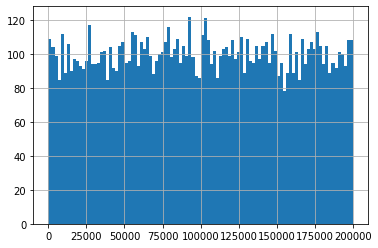

In [279]:
data['EstimatedSalary'].hist(bins=100);

**Можно сделать вывод, что срез данных из общей БД сделан был таким образом, чтобы в равной степени были представлены клиенты с различными уровнями предполагаемой заработной платы.**

**Можно заметить, что у нас всего 3 признака (`'Surname'`, `'Geography'`, `'Gender'`) с нечисленным типом данных, которые придется впоследствии преобразовать методикой OHE (One-Hot Encoding) для обучения моделей машинного обучения.**

**Также можно видеть пропуски в признаке `'Tenure'`. Неизвестно, насколько сильно данный признак связан с целевым. Проверим это.**

In [280]:
data_no_na = data.dropna()
display(data_no_na['Tenure'].isna().sum())
data_no_na.corrwith(data_no_na['Tenure'])

0

RowNumber         -0.007322
CustomerId        -0.021418
CreditScore       -0.000062
Age               -0.013134
Tenure             1.000000
Balance           -0.007911
NumOfProducts      0.011979
HasCrCard          0.027232
IsActiveMember    -0.032178
EstimatedSalary    0.010520
Exited            -0.016761
dtype: float64

**Сильной корреляции между признаком `'Tenure'` и остальными числовыми признаками не наблюдается.**

**Проверим, какой процент от общего количества данных пропущен в признаке `'Tenure'`.**

In [281]:
data['Tenure'].isna().sum()/data.shape[0]

0.0909

**9 процентов меньше граничного значения в 10%, но попробуем сохранить и эти данные, заполнив пропуски в признаке `'Tenure'`. Можно, конечно, пропуски заполнить, обучив модель на других признаках, и сделав `'Tenure'` целевым признаком, но поступим более просто - заполним пропуски в признаке `'Tenure'` медианным значением.**

In [282]:
df = data.fillna(data['Tenure'].median())
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


**Оценим уникальные значения признака `'Tenure'`.**

In [283]:
df['Tenure'].unique()

array([ 2.,  1.,  8.,  7.,  4.,  6.,  3., 10.,  5.,  9.,  0.])

**Видим, что все значения целочисленные, изменим тип на целочисленный.**

In [284]:
df['Tenure'] = df['Tenure'].astype('int64')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


**Посмотрим на данные в признаке `'Surname'`. Узнаем, как часто встречаются определенные фамилии в датафрейме, нет ли там какой-то специфики.**

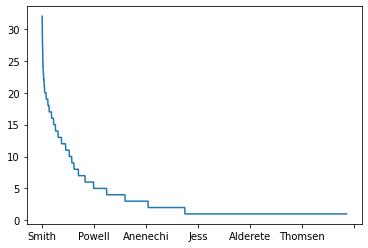

In [285]:
df['Surname'].value_counts().plot();

**Видим, что какого-то нестандартного распределения и "перекоса" данных не наблюдается в фамилиях, всё достаточно стандартно. Фамилия относится к ID человека и в общем случае не должна влиять на его поведение и, соответственно, на вероятность ухода из банка.**

**Посмотрим, какое количество уникальных фамилий содержат данные.**

In [286]:
df['Surname'].nunique()

2932

**Т.к. мы решили, что фамилия в общем случае не должна влиять на вероятность ухода из банка и количество уникальных фамилий равно 2932, то для более качественного и более быстрого обучения наших моделей будет логично удалить данный признак, иначе при использовании методики OHE мы получим еще дополнительно 2931 столбец, что еще дополнительно перегрузит наш датасет и увеличит время работы алгоритмов.** 

**При этом признаки `'RowNumber'` — индекс строки в данных и `'CustomerId'` — уникальный идентификатор клиента также никак не могут влиять на вероятность ухода клиента, удалим и данные признаки.**

In [287]:
df = df.drop(['Surname', 'RowNumber', 'CustomerId'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


**Проверим на дубликаты и неявные дубликаты остальные нечисловые признаки.**

In [288]:
display(df['Gender'].value_counts())
df['Geography'].value_counts()

Male      5457
Female    4543
Name: Gender, dtype: int64

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

**Видим, что дубликатов нет и уникальные значения адекватны.**

**Теперь используя методику OHE подготовим данные.**

In [289]:
data_ohe = pd.get_dummies(df, drop_first=True)
data_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        10000 non-null  int64  
 1   Age                10000 non-null  int64  
 2   Tenure             10000 non-null  int64  
 3   Balance            10000 non-null  float64
 4   NumOfProducts      10000 non-null  int64  
 5   HasCrCard          10000 non-null  int64  
 6   IsActiveMember     10000 non-null  int64  
 7   EstimatedSalary    10000 non-null  float64
 8   Exited             10000 non-null  int64  
 9   Geography_Germany  10000 non-null  uint8  
 10  Geography_Spain    10000 non-null  uint8  
 11  Gender_Male        10000 non-null  uint8  
dtypes: float64(2), int64(7), uint8(3)
memory usage: 732.5 KB


**Проверим, насколько в наших данных сбалансированы классы целевого признака.**

In [290]:
data_ohe['Exited'].value_counts(normalize=True)

0    0.7963
1    0.2037
Name: Exited, dtype: float64

**Видим, что соотношение классов почти 1 к 4, имеет дисбаланс классов. Сначала посмотрим качество моделей без устранения дисбаланса классов, а далее уже посмотрим на качество моделей после устранения дисбаланса классов.**

**В случае нашей задачи целевой признак (который нужно предсказать) - `'Exited'`, он означает уйдет ли заказчик. Значения этого признака могут быть либо 0, либо 1, соответственно, в данном случае перед нами стоит задача бинарной классификации.**

**Т.к. у нас нет "спрятанной" тестовой выборки, то данные необходимо разбить на три части: обучающую, валидационную и тестовую выборки. Выберем равные размеры тестового и валидационного наборов.** 

**Соответственно, исходные данные разобьем в соотношении 3 : 1 : 1, т.е. 0.6 : 0.2 : 0.2**

**Функция `'train_test_split'` делит только на две части датасет, поэтому чтобы получить 3 случайно сформированные выборки нужного относительного размера, применим данную функцию два раза.**

**Далее разделим каждую из трех частей на две части - признаки и целевой признак.**

In [291]:
data_part, data_valid = train_test_split(data_ohe, test_size=0.2, random_state=1)
data_train, data_test = train_test_split(data_part, test_size=0.25, random_state=1)

display(data_train.shape)
display(data_valid.shape)
data_test.shape

(6000, 12)

(2000, 12)

(2000, 12)

In [292]:
features_train = data_train.drop('Exited', axis=1)
target_train = data_train['Exited']

features_valid = data_valid.drop('Exited', axis=1)
target_valid = data_valid['Exited']

features_test = data_test.drop('Exited', axis=1)
target_test = data_test['Exited']


display(features_train.shape, target_train.shape)
display(features_valid.shape, target_valid.shape)
display(features_test.shape, target_test.shape)

(6000, 11)

(6000,)

(2000, 11)

(2000,)

(2000, 11)

(2000,)

**В данных есть признаки с большой абсолютной разницей в разбросе значений. Как известно, алгоритм автоматически решает, что признак с большими значениями важнее, но это не так: все признаки значимы. Чтобы устранить это, масштабируем признаки с помощью стандартизации данных.**

**Для этого будем использовать отдельную структуру для стандартизации данных — StandardScaler из модуля sklearn.preprocessing.**

In [293]:
features_train_scaled = features_train.copy()
features_valid_scaled = features_valid.copy() 
features_test_scaled = features_test.copy() 

pd.options.mode.chained_assignment = None # чтобы устранить известное предупреждение при исп-нии StandardScaler
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary'] # масш-мые признаки

scaler = StandardScaler()
scaler.fit(features_train[numeric]) 

features_train_scaled[numeric] = scaler.transform(features_train_scaled[numeric])
features_valid_scaled[numeric] = scaler.transform(features_valid_scaled[numeric])
features_test_scaled[numeric] = scaler.transform(features_test_scaled[numeric])

display(features_train_scaled.head())
display(features_valid_scaled.head())
display(features_test_scaled.head())

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
4495,1.427934,-0.656100,0.722340,-0.113714,-0.905397,1,0,0.134255,0,0,0
6470,-0.705851,0.198238,-0.006621,0.018224,-0.905397,1,0,1.572963,1,0,0
2221,1.200054,-0.371320,0.357859,0.894255,-0.905397,1,0,0.274208,1,0,0
7686,0.692503,0.862723,1.451301,-1.227467,0.805051,1,1,-0.479772,0,0,1
9419,0.361041,-1.225658,-1.464544,-0.306243,-0.905397,1,1,-0.356880,1,0,1


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
9953,-1.047671,0.767796,-1.100063,-1.227467,0.805051,1,1,-0.046900,0,0,1
3850,0.298892,-0.466247,-0.735583,1.071364,-0.905397,1,0,-0.576570,0,0,1
4962,-1.244477,0.293164,-1.100063,-1.227467,0.805051,0,1,-0.160008,0,0,0
3886,0.609638,-0.466247,1.086821,1.144204,0.805051,0,1,-1.703601,1,0,1
5437,-1.120179,-0.845952,0.357859,-0.048620,-0.905397,1,1,1.334650,1,0,1


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
7857,2.059783,-1.130732,0.357859,0.323152,0.805051,0,0,0.919111,0,0,1
9924,-0.198300,1.052576,-0.006621,0.504512,-0.905397,1,1,-1.609508,1,0,0
3087,-2.197429,-0.276394,-1.100063,1.428211,0.805051,1,1,0.419765,0,0,1
3513,1.438292,-0.561173,1.815782,0.940258,-0.905397,0,0,1.655810,0,0,0
2105,-1.648446,-0.751026,0.722340,-1.227467,0.805051,1,1,-0.872579,0,0,0


**Данные подготовлены. Переходим к исследованию.**

## Исследование задачи

**Будем использовать модель "Случайный лес".**

**Самые важные гиперпараметры алгоритма классификации случайный лес: 'max_depth' - глубина, 'n_estimators' - количество деревьев в лесу. Определим, при каких значениях 'max_depth' и 'n_estimators' мы получим наилучшее качество данной модели на валидационной выборке и определим само значение этого качества.**

**Сначала выберем оптимальную глубину при небольшом кол-ве деревьев, а далее будем увеличивать кол-во деревьев.**

In [294]:
best_model_random_forest = None
best_f1_random_forest = 0
best_depth_random_forest = 0

for depth in range (1, 20):
    model_random_forest = RandomForestClassifier(random_state=1, n_estimators=20, max_depth=depth, criterion='entropy')
    model_random_forest.fit(features_train_scaled, target_train)       
    predicted_valid = model_random_forest.predict(features_valid_scaled)

    # посчитаем метрику f1-мера модели на валидационной выборке
    f1_random_forest = f1_score(target_valid, predicted_valid)
    if f1_score(target_valid, predicted_valid) > best_f1_random_forest:
         # сохраняем наилучшую модель
        best_model_random_forest = model_random_forest
        
        # сохраняем наилучшее значение метрики f1-мера на валидационных данных
        best_f1_random_forest = f1_random_forest  
        best_depth_random_forest = depth # сохраняем наилучшее значение глубины
print(f'Лучший результат модели "Случайный лес" при:\n max_depth = {best_depth_random_forest}\n f1 = {best_f1_random_forest}')

Лучший результат модели "Случайный лес" при:
 max_depth = 12
 f1 = 0.5929339477726575


**Теперь будем увеличивать кол-во деревьев в лесу.**

In [295]:
best_model_random_forest = None
best_f1_random_forest = 0
best_est_random_forest = 0

for est in range (1, 50, 1):
    model_random_forest = RandomForestClassifier(random_state=1, n_estimators=est, max_depth=12, criterion='entropy')
    model_random_forest.fit(features_train_scaled, target_train)       
    predicted_valid = model_random_forest.predict(features_valid_scaled)

    # посчитаем метрику f1-мера модели на валидационной выборке
    f1_random_forest = f1_score(target_valid, predicted_valid)
    if f1_score(target_valid, predicted_valid) > best_f1_random_forest:
         # сохраняем наилучшую модель
        best_model_random_forest = model_random_forest
        
        # сохраняем наилучшее значение метрики f1-мера на валидационных данных
        best_f1_random_forest = f1_random_forest  
        best_est_random_forest = est # сохраняем наилучшее значение кол-ва деревьев
print(f'Лучший результат модели "Случайный лес" при:\n est = {best_est_random_forest}\n f1 = {best_f1_random_forest}')

Лучший результат модели "Случайный лес" при:
 est = 17
 f1 = 0.6021505376344086


**Проверим, какое значение AUC-ROC для данной модели с указанными значениями гиперпараметров мы получим на валидационной выборке. Помним, что значение 0.5 соответствует случайной модели.**

In [296]:
probabilities_valid = best_model_random_forest.predict_proba(features_valid_scaled)
probabilities_one_valid = probabilities_valid[:, 1]
roc_auc_score(target_valid, probabilities_one_valid)

0.8662582189958572

**На валидационной выборке получили значение AUC-ROC значительно выше, чем у случайной модели.**

**Промежуточный вывод:**

**Мы получили наилучший результат f1-меры выше 0.59 для валидационной выборки, что удовлетворяет исходному заданию. Такой результат удалось получить для "Случайного леса" со следующими параметрами:**
- criterion = 'entropy'
- n_estimators = 17
- max_depth = 12

**Для этой же обученной модели на валидационной выборке получили значение AUC-ROC значительно выше, чем у случайной модели.**

## Борьба с дисбалансом

**Устранить дисбаланс классов можно двумя способами - увеличив класс, который в просадке, либо же наоборот - уменьшив класс, который в избытке.**

**Попробуем 1й сценарий - увеличив класс, который находится в просадке. Для этого напишем функцию.**

In [261]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=1)
    
    return features_upsampled, target_upsampled

one_count = features_train_scaled[target_train == 1].shape[0] #кол-во единиц
zero_count = features_train_scaled[target_train == 0].shape[0] #кол-во нулей
mult_koef = round(zero_count/one_count) # коэффициент увеличения выборки

features_upsampled, target_upsampled = upsample(features_train_scaled, target_train, mult_koef)

display(features_upsampled.shape)
display(target_upsampled.shape)

# проверка соотношения 0 и 1 в расширенной выборке
features_upsampled[target_upsampled == 1].shape[0] / features_upsampled[target_upsampled == 0].shape[0] 

(9621, 11)

(9621,)

1.007302315877321

In [262]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=1)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=1)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=1)
    
    return features_downsampled, target_downsampled

one_count = features_train_scaled[target_train == 1].shape[0] #кол-во единиц
zero_count = features_train_scaled[target_train == 0].shape[0] #кол-во нулей
div_koef = one_count/zero_count # коэффициент уменьшения выборки

features_downsampled, target_downsampled = downsample(features_train_scaled, target_train, div_koef)

display(features_downsampled.shape)
display(target_downsampled.shape)

# проверка соотношения 0 и 1 в суженной выборке
features_downsampled[target_downsampled == 1].shape[0] / features_downsampled[target_downsampled == 0].shape[0] 

(2414, 11)

(2414,)

1.0

**Произведем еще раз поиск гиперпараметров модели "Случайный лес", дающих наилучший результат f1-меры на новых сбалансированных обучающих выборках.**

**Сначала выберем оптимальную глубину при небольшом кол-ве деревьев, а далее будем увеличивать кол-во деревьев.**

**Начнем с расширенной выборки.**

In [267]:
best_model_random_forest = None
best_f1_random_forest = 0
best_depth_random_forest = 0

for depth in range (1, 20):
    model_random_forest = RandomForestClassifier(random_state=1, n_estimators=20, max_depth=depth, criterion='entropy')
    model_random_forest.fit(features_upsampled, target_upsampled)       
    predicted_valid = model_random_forest.predict(features_valid_scaled)

    # посчитаем метрику f1-мера модели на валидационной выборке
    f1_random_forest = f1_score(target_valid, predicted_valid)
    if f1_score(target_valid, predicted_valid) > best_f1_random_forest:
         # сохраняем наилучшую модель
        best_model_random_forest = model_random_forest
        
        # сохраняем наилучшее значение метрики f1-мера на валидационных данных
        best_f1_random_forest = f1_random_forest  
        best_depth_random_forest = depth # сохраняем наилучшее значение глубины
print(f'Лучший результат модели "Случайный лес" при:\n max_depth = {best_depth_random_forest}\n f1 = {best_f1_random_forest}')

Лучший результат модели "Случайный лес" при:
 max_depth = 10
 f1 = 0.6297117516629712


**Теперь будем увеличивать кол-во деревьев в лесу.**

In [269]:
best_model_random_forest = None
best_f1_random_forest = 0
best_est_random_forest = 0

for est in range (1, 50, 1):
    model_random_forest = RandomForestClassifier(random_state=1, n_estimators=est, max_depth=10, criterion='entropy')
    model_random_forest.fit(features_upsampled, target_upsampled)       
    predicted_valid = model_random_forest.predict(features_valid_scaled)

    # посчитаем метрику f1-мера модели на валидационной выборке
    f1_random_forest = f1_score(target_valid, predicted_valid)
    if f1_score(target_valid, predicted_valid) > best_f1_random_forest:
         # сохраняем наилучшую модель
        best_model_random_forest = model_random_forest
        
        # сохраняем наилучшее значение метрики f1-мера на валидационных данных
        best_f1_random_forest = f1_random_forest  
        best_est_random_forest = est # сохраняем наилучшее значение кол-ва деревьев
print(f'Лучший результат модели "Случайный лес" при:\n est = {best_est_random_forest}\n f1 = {best_f1_random_forest}')

Лучший результат модели "Случайный лес" при:
 est = 23
 f1 = 0.6320441988950276


**Теперь сделаем то же самое, но для суженной выборки.**

In [270]:
best_model_random_forest = None
best_f1_random_forest = 0
best_depth_random_forest = 0

for depth in range (1, 20):
    model_random_forest = RandomForestClassifier(random_state=1, n_estimators=20, max_depth=depth, criterion='entropy')
    model_random_forest.fit(features_downsampled, target_downsampled)       
    predicted_valid = model_random_forest.predict(features_valid_scaled)

    # посчитаем метрику f1-мера модели на валидационной выборке
    f1_random_forest = f1_score(target_valid, predicted_valid)
    if f1_score(target_valid, predicted_valid) > best_f1_random_forest:
         # сохраняем наилучшую модель
        best_model_random_forest = model_random_forest
        
        # сохраняем наилучшее значение метрики f1-мера на валидационных данных
        best_f1_random_forest = f1_random_forest  
        best_depth_random_forest = depth # сохраняем наилучшее значение глубины
print(f'Лучший результат модели "Случайный лес" при:\n max_depth = {best_depth_random_forest}\n f1 = {best_f1_random_forest}')

Лучший результат модели "Случайный лес" при:
 max_depth = 8
 f1 = 0.6069364161849712


In [271]:
best_model_random_forest = None
best_f1_random_forest = 0
best_est_random_forest = 0

for est in range (1, 50, 1):
    model_random_forest = RandomForestClassifier(random_state=1, n_estimators=est, max_depth=8, criterion='entropy')
    model_random_forest.fit(features_downsampled, target_downsampled)       
    predicted_valid = model_random_forest.predict(features_valid_scaled)

    # посчитаем метрику f1-мера модели на валидационной выборке
    f1_random_forest = f1_score(target_valid, predicted_valid)
    if f1_score(target_valid, predicted_valid) > best_f1_random_forest:
         # сохраняем наилучшую модель
        best_model_random_forest = model_random_forest
        
        # сохраняем наилучшее значение метрики f1-мера на валидационных данных
        best_f1_random_forest = f1_random_forest  
        best_est_random_forest = est # сохраняем наилучшее значение кол-ва деревьев
print(f'Лучший результат модели "Случайный лес" при:\n est = {best_est_random_forest}\n f1 = {best_f1_random_forest}')

Лучший результат модели "Случайный лес" при:
 est = 45
 f1 = 0.6147859922178988


**Видим, что во-первых величина критерия f1-меры выросла по-сравнению с обучением с помощью выборки с несбалансированными классами. Во-вторых, балансировка расширением выборки дала результат лучше, что логично, т.к. данных в данном случае было больше.**

**Наилучшие результаты f1-меры = 0.632 получены для валидационной выборки, что удовлетворяет исходному заданию. Такой результат удалось получить для "Случайного леса" на расширенной сбалансированной выборке со следующими параметрами:**
- criterion = 'entropy'
- n_estimators = 23
- max_depth = 10

**Проверим, какое значение AUC-ROC для данной модели с указанными значениями гиперпараметров мы получим. Помним, что значение 0.5 соответствует случайной модели.**

In [299]:
model_random_forest = RandomForestClassifier(random_state=1, n_estimators=23, max_depth=10, criterion='entropy')
model_random_forest.fit(features_upsampled, target_upsampled)   
probabilities_valid = model_random_forest.predict_proba(features_valid_scaled)
probabilities_one_valid = probabilities_valid[:, 1]
roc_auc_score(target_valid, probabilities_one_valid)

0.8636889513891528

**На валидационной выборке получили значение AUC-ROC значительно выше, чем у случайной модели.**

**Проверим нашу модель с выбранными гиперпараметрами на тестовой выборке.**

In [205]:
model_random_forest = RandomForestClassifier(random_state=1, n_estimators=51, max_depth=7)
model_random_forest.fit(features_upsampled, target_upsampled)       
predicted_test = model_random_forest.predict(features_test_scaled)
f1_random_forest = f1_score(target_valid, predicted_test)
f1_random_forest

0.5977249224405378

**Получили удовлетворительное условиям задачи значение f1-меры, цель достигнута.**

**Проверим, какое значение AUC-ROC (площадь под кривой ROC) для данной модели мы получаем. Помним, что значение 0.5 соответствует случайной модели.**

In [210]:
roc_auc_score(target_test, predicted_test)

0.6790923948158566

**Значение AUC-ROC при этом выше 0.5 случайной модели, что дополнительно еще раз положительным образом характеризует полученный нами результат.**

## Тестирование модели

**Проверим нашу модель с выбранными гиперпараметрами на тестовой выборке.**

In [304]:
model_random_forest = RandomForestClassifier(random_state=1, n_estimators=23, max_depth=10, criterion='entropy')
model_random_forest.fit(features_upsampled, target_upsampled)  

predicted_test = model_random_forest.predict(features_test_scaled)

# посчитаем метрику f1-мера модели на тестовой выборке
f1_random_forest = f1_score(target_test, predicted_test)
print('f1_test =',f1_random_forest)

probabilities_test = model_random_forest.predict_proba(features_test_scaled)
probabilities_one_test = probabilities_test[:, 1]
print('ROC_AUC_test =',roc_auc_score(target_test, probabilities_one_test))

f1_test = 0.5980707395498392
ROC_AUC_test = 0.8326281783284557


**Итак, на тестовой выборке обученная модель показала себя удовлетворительно, достигнув значения метрики f1-мера = 0.598, что выше заявленных в задании 0.59 и значение метрики ROC-AUC составило 0.833, что также значительно превышает результаты, характерные для случайной модели.**

**Выводы.**

**Для решения поставленной задачи наилучшим образом показала себя модель "Случайный лес" с гиперпараметрами**

- criterion = 'entropy' 
- n_estimators = 23
- max_depth = 10 

**Обученная на сбалансированной расширенной выборке, данные которой были предварительно масштабированы с помощью стандартизации и прошли предподготовку.**

**Балансировка классов принесла улучшение f1-меры.**